In [1]:
import os
from enum import Enum, auto
import glob

import cv2
import matplotlib.pyplot as plt
import tqdm


class CASCADE(Enum):
    DEFAULT = auto()
    ALT = auto()
    ALT2 = auto()
    ALT_TREE = auto()
    UPPER_BODY = auto()
    FULL_BODY = auto()

    
class DetectFace:
    face_cascade = None
    
    def __init__(self, image_path):
        self.img_path = image_path

    @classmethod
    def set_cascade(cls, cascade: CASCADE):
        cascade_dir = './opencv'
        cascade_map = {
            CASCADE.DEFAULT: 'haarcascade_frontalface_default.xml',
            CASCADE.ALT: 'haarcascade_frontalface_alt.xml',
            CASCADE.ALT2: 'haarcascade_frontalface_alt2.xml',
            CASCADE.ALT_TREE: 'haarcascade_frontalface_alt_tree.xml',
            CASCADE.UPPER_BODY: 'haarcascade_upperbody.xml',
            CASCADE.FULL_BODY: 'haarcascade_fullbody.xml',
        }
        cls.face_cascade = cv2.CascadeClassifier(f'{cascade_dir}/{cascade_map[cascade]}')
        
    @property
    def file_name(self):
        return os.path.basename(self.img_path)
        
    @property
    def image_name(self):
        return self.file_name.split('.')[0]
    
    @property
    def extention(self):
        return self.file_name.split('.')[-1]
    
    def detect_faces(self):
        img = cv2.imread(image_path, cv2.IMREAD_COLOR)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        faces = self.face_cascade.detectMultiScale(gray, 1.1, 3)
        return img, faces
    
    def show(self, ax, detected=True):
        img, faces = self.detect_faces()
        if detected:
            for (x, y, w, h) in faces:
                cv2.rectangle(img=img, pt1=(x, y), pt2=(x+w, y+h), color=(0, 0, 255), thickness=3)
        ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax.set_title(self.file_name)
    
    def output_faces(self, dir_path):
        img, faces = self.detect_faces()
        for idx, (x, y, w, h) in enumerate(faces):
            os.makedirs(dir_path, exist_ok=True)
            output_path = f'{dir_path}/{self.image_name}_{self.extention}_{idx+1}.jpg'
            cv2.imwrite(output_path, img[y:y+h, x:x+w])

## どの検出器を使うのが良いのか
- 今回は取りこぼしの少なさと誤検出の少なさのバランスの良さそうな alt を使う
- 傾向
    - default : 取りこぼしは少ないが、誤検出が多い
    - alt     : たまに取りこぼすが、誤検出は少ない
    - alt2    : altと大きくは変わらないが、若干取りこぼしが多い気がする
    - alt_tree: ほとんど検出できない。用途が違う？

100% 10/10 [00:09<00:00,  1.02it/s]
100% 10/10 [00:14<00:00,  1.45s/it]
100% 10/10 [00:13<00:00,  1.35s/it]
100% 10/10 [00:10<00:00,  1.04s/it]


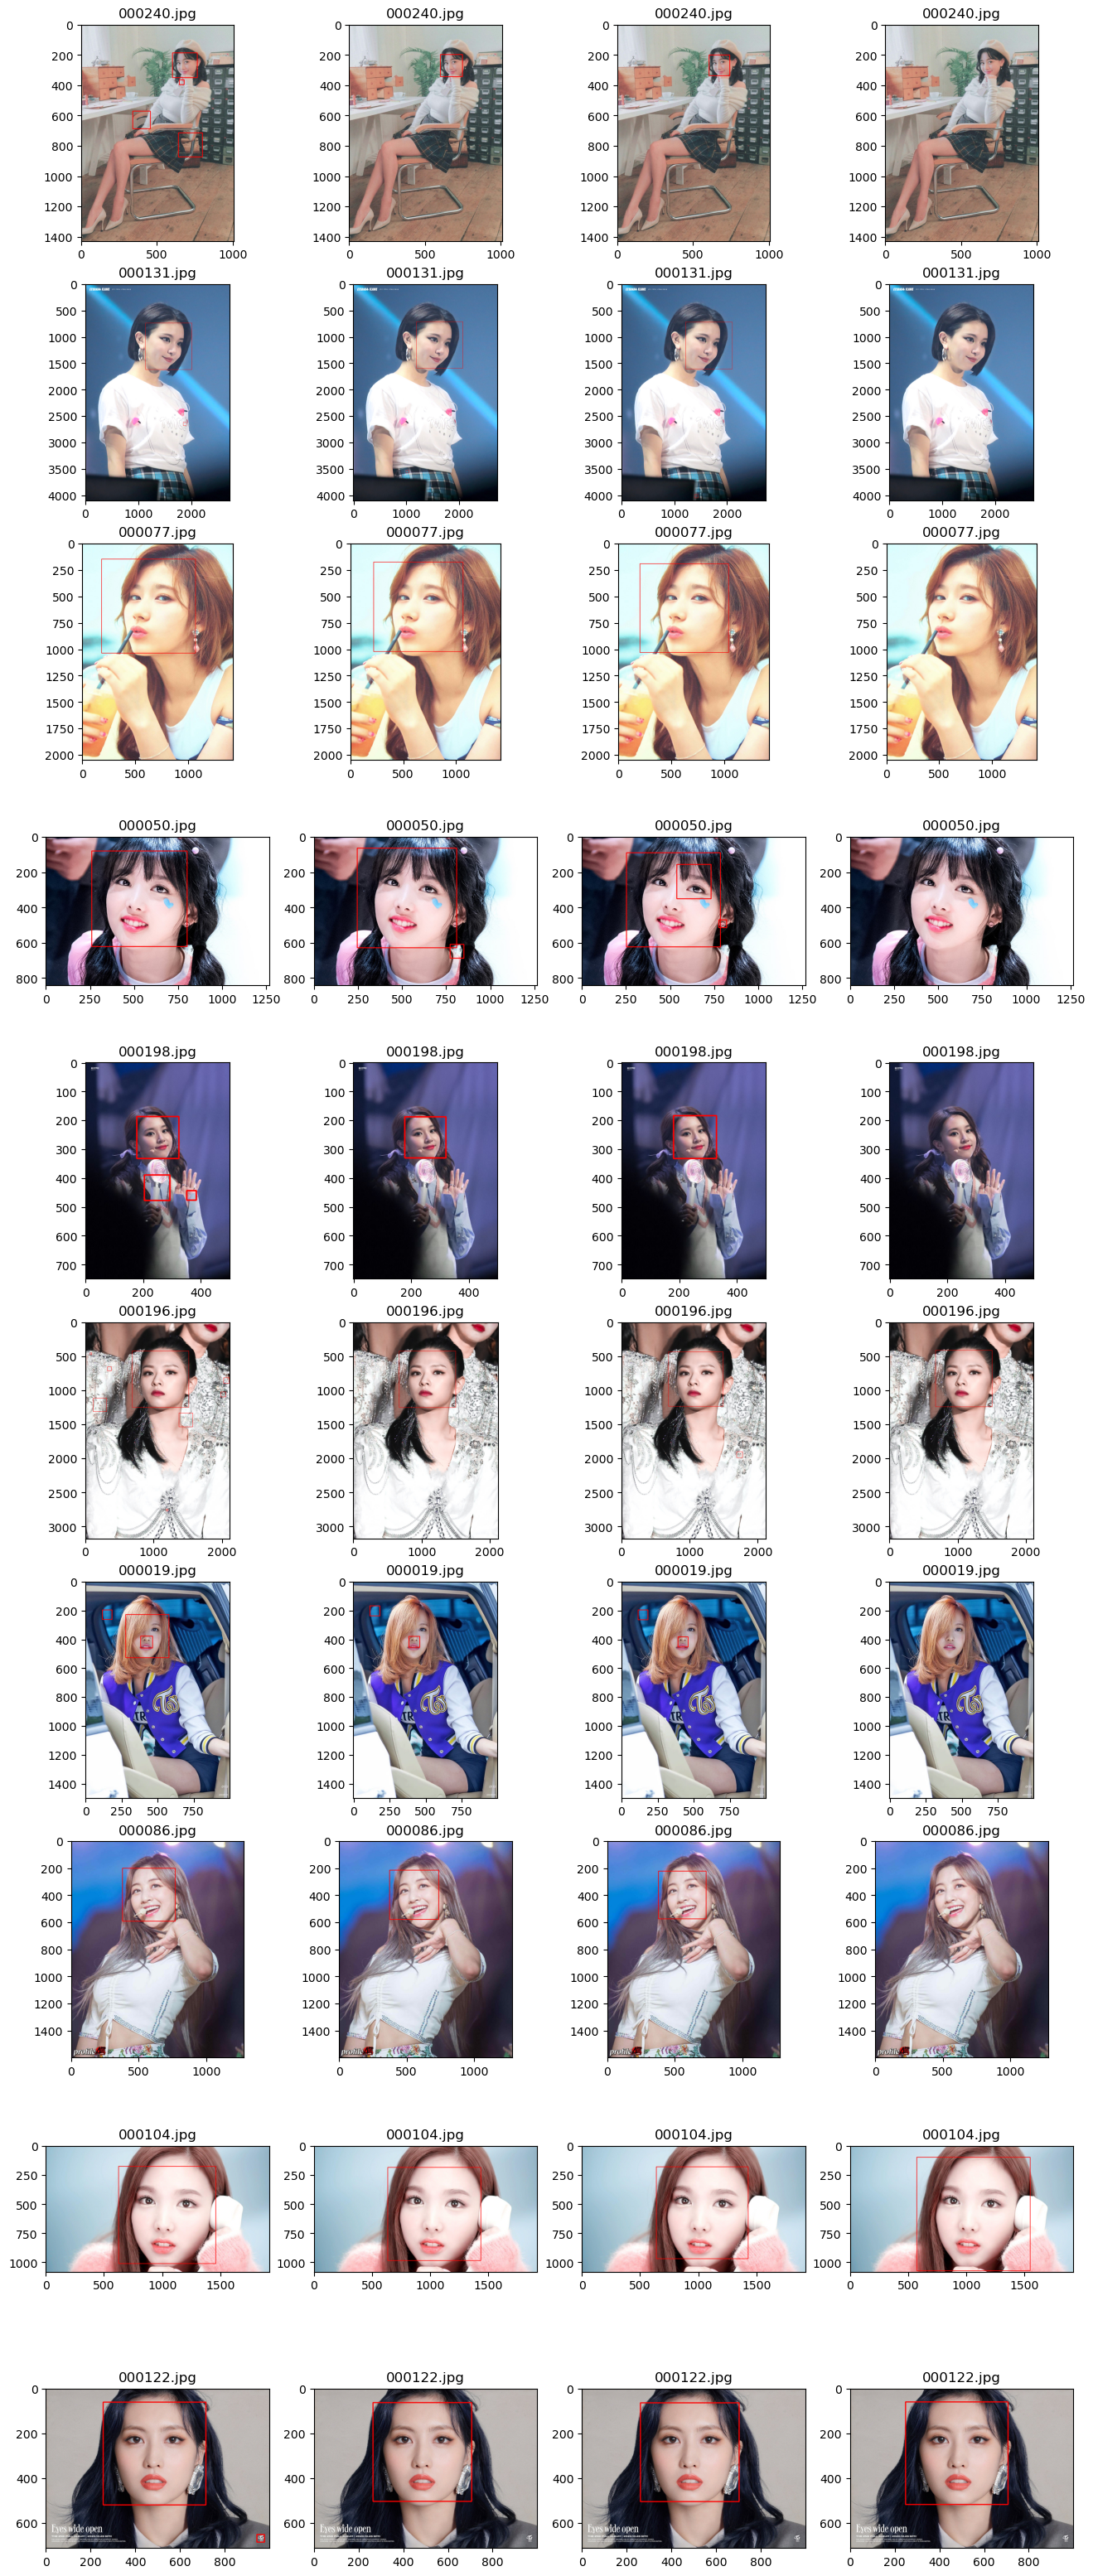

In [11]:
# 各検出機の顔検出の様子を比較
from image_util import ImageUtil

IMAGE_ROOT = './images'
SAMPLE_NUM = 10
cascade_list = [
    CASCADE.DEFAULT,
    CASCADE.ALT,
    CASCADE.ALT2,
    CASCADE.ALT_TREE,
]

util = ImageUtil(IMAGE_ROOT)
df = util.images_df()
df = df.sample(SAMPLE_NUM)

ROW_NUM = len(df)
COL_NUM = len(cascade_list)
fig, axes = plt.subplots(ROW_NUM, COL_NUM, figsize=(4*COL_NUM, 4*ROW_NUM))

for cascade_idx, cascade in enumerate(cascade_list):
    DetectFace.set_cascade(cascade)
    axes_cascade = axes[:, cascade_idx]

    for idx, image_path in enumerate(tqdm.tqdm(df['path'])):
        detect = DetectFace(image_path)
        detect.show(ax=axes_cascade[idx])

## 検出した顔画像の出力

In [4]:
# 全画像の顔を検出して出力
from image_util import ImageUtil

IMAGE_ROOT = './images'
CASCADE_TYPE = CASCADE.ALT

util = ImageUtil(IMAGE_ROOT)
df = util.images_df()
DetectFace.set_cascade(CASCADE_TYPE)

for idx, image_path in enumerate(tqdm.tqdm(df['path'])):
    detect = DetectFace(image_path)
    dir_path = os.path.dirname(image_path).replace('/images/', '/images_faces/')
    
    if os.path.exists(f'{dir_path}/{detect.image_name}_{detect.extention}_1.jpg'):
        # すでに出力済だったらスキップ
        continue

    try:
        detect.output_faces(dir_path)
    except Exception as e:
        print(f'Error: image_path: {image_path}')
        print(e)

 92% 2063/2238 [08:21<00:33,  5.15it/s]

Error: image_path: ./images/train/TZUYU/000182.jpg
OpenCV(4.7.0) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'



 95% 2131/2238 [09:24<03:55,  2.20s/it]libpng warning: iCCP: known incorrect sRGB profile
 97% 2164/2238 [10:23<02:03,  1.67s/it]

Error: image_path: ./images/train/TZUYU/000314.jpg
OpenCV(4.7.0) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'



 99% 2222/2238 [11:18<00:18,  1.17s/it]

Error: image_path: ./images/train/TZUYU/000390.jpg
OpenCV(4.7.0) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'



100% 2238/2238 [11:33<00:00,  3.23it/s]
